In [1]:
import os
import json
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import time
import math
import sklearn
import random
import pickle 
%matplotlib inline
sns.set(style="whitegrid")

2025-05-14 11:03:48.148450: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 11:03:49.433956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747202629.889717     452 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747202630.007990     452 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747202631.083815     452 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
DATASET_PATH = r"/mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/genres_original" # Root folder of GTZAN dataset
JSON_PATH = r"/mnt/e/lab/Abdul_Rehman_Feb_New/AML/data_gzgan.json" # To save file list and labels mapping
FEATURES_PATH = "processed_features_mel_spec_notebook.npz" # To save extracted features
MODEL_SAVE_PATH = "denseNet(201)_50layers.h5" # To save the trained model
LABEL_MAP_PATH = "genre_label_mapping_notebook.json" # To save genre name mapping

SAMPLE_RATE = 22050
DURATION = 30  # seconds (original duration)
SEGMENT_DURATION = 3 # seconds (segment length for CNN input)
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
SAMPLES_PER_SEGMENT = int(SAMPLE_RATE * SEGMENT_DURATION) # Ensure integer
NUM_SEGMENTS_PER_TRACK = int(SAMPLES_PER_TRACK / SAMPLES_PER_SEGMENT) # Ensure integer

# Feature Extraction Parameters (Focusing on Mel-Spectrograms as per common CNN practice)
N_MELS = 128 # Number of Mel bands
N_FFT = 2048 # Window size for FFT
HOP_LENGTH = 512 # Samples between successive frames

# Data Split Parameters
TEST_SIZE = 0.15 # 15% for final testing
VALIDATION_SIZE = 0.15 # 15% for validation during training

# Training Parameters (Example - Step 5 discusses tuning)
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

# --- Data Loading Function ---
def load_data_paths_and_labels(dataset_path):
    """Scans the dataset directory and returns lists of file paths and labels."""
    if not os.path.exists(dataset_path):
        raise ValueError(f"Dataset path not found: {dataset_path}")

    all_files = []
    all_labels = []
    genre_mapping = {}
    genres = [g for g in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, g))]
    genres.sort() # Ensure consistent order

    for i, genre in enumerate(genres):
        genre_mapping[i] = genre
        genre_path = os.path.join(dataset_path, genre)
        for filename in os.listdir(genre_path):
            if filename.lower().endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                all_files.append(file_path)
                all_labels.append(i) # Use integer index as label

    print(f"Found {len(all_files)} audio files across {len(genres)} genres.")
    if len(all_files) == 0:
        raise ValueError(f"No .wav files found in {dataset_path} or its subdirectories.")

    return all_files, all_labels, genre_mapping

# --- Load Initial Data ---
try:
    all_files, all_labels_int, genre_mapping = load_data_paths_and_labels(DATASET_PATH)
    # Save the mapping for later use
    with open(LABEL_MAP_PATH, 'w') as f:
        json.dump(genre_mapping, f, indent=4)
    print("Genre Mapping:", genre_mapping)
    print(f"Data loading successful. Number of files: {len(all_files)}, Number of labels: {len(all_labels_int)}")
except ValueError as e:
    print(f"Error during data loading: {e}")
    # Stop execution if data isn't loaded
    raise SystemExit("Stopping execution due to data loading error.")

# Create a Pandas DataFrame for easier handling (optional but good for EDA)
data_df = pd.DataFrame({
    'file_path': all_files,
    'label_int': all_labels_int
})
# Map integer labels to genre names
data_df['genre'] = data_df['label_int'].map(genre_mapping)
print("\nSample of the data:")
print(data_df.head())

Found 1000 audio files across 10 genres.
Genre Mapping: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
Data loading successful. Number of files: 1000, Number of labels: 1000

Sample of the data:
                                           file_path  label_int  genre
0  /mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/...          0  blues
1  /mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/...          0  blues
2  /mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/...          0  blues
3  /mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/...          0  blues
4  /mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/...          0  blues


Loading features from processed_features_mel_spec_notebook.npz...
Features loaded successfully. Shape: (9981, 128, 130), Labels shape: (9981,)


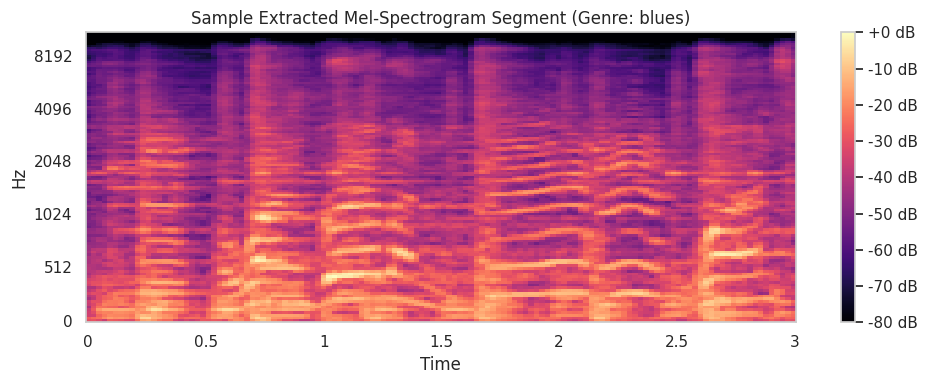

In [3]:
# --- Feature Extraction Function ---
def extract_features(file_paths, labels_int, sr, n_mels, n_fft, hop_length, segment_duration, num_segments_per_track):
    """Extracts Mel-Spectrogram features from audio files and segments them."""
    start_time = time.time()
    processed_features = []
    processed_labels = []

    samples_per_segment = int(sr * segment_duration)
    num_expected_vectors_per_segment = math.ceil(samples_per_segment / hop_length) # Expected time steps
    print(f"Starting feature extraction... Expected samples/segment: {samples_per_segment}, Expected Mel vectors/segment: {num_expected_vectors_per_segment}")

    for i, file_path in enumerate(file_paths):
        if (i + 1) % 50 == 0: # Print progress
             print(f"  Processing file {i+1}/{len(file_paths)}: {os.path.basename(file_path)}")
        try:
            signal, current_sr = librosa.load(file_path, sr=sr)

            # Ensure track is long enough for at least one full segment (robustness)
            if len(signal) < samples_per_segment:
                 print(f"  Warning: Skipping {os.path.basename(file_path)} (shorter than one segment: {len(signal)} < {samples_per_segment})")
                 continue

            # Process segments
            for s in range(num_segments_per_track):
                start_sample = s * samples_per_segment
                finish_sample = start_sample + samples_per_segment

                # Check boundary conditions
                if finish_sample > len(signal):
                     # print(f"    Segment {s+1} exceeds track length for {os.path.basename(file_path)}. Skipping remaining.")
                     break # Stop processing segments for this file if out of bounds

                audio_segment = signal[start_sample:finish_sample]

                # Extract Mel-Spectrogram
                mel_spec = librosa.feature.melspectrogram(y=audio_segment, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

                # Ensure fixed shape
                if log_mel_spec.shape == (n_mels, num_expected_vectors_per_segment):
                    processed_features.append(log_mel_spec)
                    processed_labels.append(labels_int[i]) # Assign original track's label to the segment
                else:
                    # Handle potential minor shape mismatches due to rounding/edge effects
                    # Common fix: Pad or truncate along the time axis (axis=1)
                    if log_mel_spec.shape[1] > num_expected_vectors_per_segment:
                        log_mel_spec = log_mel_spec[:, :num_expected_vectors_per_segment]
                    elif log_mel_spec.shape[1] < num_expected_vectors_per_segment:
                        pad_width = num_expected_vectors_per_segment - log_mel_spec.shape[1]
                        log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant')
                    
                    if log_mel_spec.shape == (n_mels, num_expected_vectors_per_segment):
                        processed_features.append(log_mel_spec)
                        processed_labels.append(labels_int[i])
                    # else: # Still mismatched after padding/truncation? Skip.
                    #     print(f"  Warning: Segment {s+1} in {os.path.basename(file_path)} has incorrect shape {log_mel_spec.shape} even after fix. Skipping.")

        except Exception as e:
            print(f"  Error processing {os.path.basename(file_path)}: {e}")

    end_time = time.time()
    print(f"\nFeature extraction finished in {end_time - start_time:.2f} seconds.")
    print(f"Total segments processed: {len(processed_features)}")

    if not processed_features:
        raise ValueError("No features were extracted.")

    return np.array(processed_features), np.array(processed_labels)


# --- Execute Feature Extraction (if file doesn't exist) ---
if not os.path.exists(FEATURES_PATH):
    print(f"Feature file '{FEATURES_PATH}' not found. Extracting features...")
    try:
        X_features, y_labels = extract_features(
            data_df['file_path'].tolist(),
            data_df['label_int'].tolist(),
            SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, SEGMENT_DURATION, NUM_SEGMENTS_PER_TRACK
        )
        # Save features and labels
        np.savez(FEATURES_PATH, features=X_features, labels=y_labels)
        print(f"Features and labels saved to {FEATURES_PATH}")
    except ValueError as e:
        print(f"Error during feature extraction: {e}")
        raise SystemExit("Stopping execution due to feature extraction error.")
    except Exception as e:
        print(f"An unexpected error occurred during feature extraction: {e}")
        raise SystemExit("Stopping execution due to unexpected feature extraction error.")

else:
    print(f"Loading features from {FEATURES_PATH}...")
    try:
        data = np.load(FEATURES_PATH)
        X_features = data['features']
        y_labels = data['labels']
        print(f"Features loaded successfully. Shape: {X_features.shape}, Labels shape: {y_labels.shape}")
        if X_features.size == 0 or y_labels.size == 0:
             raise ValueError("Loaded features or labels are empty.")
    except Exception as e:
        print(f"Error loading features from {FEATURES_PATH}: {e}")
        print("Corrupted file detected. Deleting and re-extracting features...")
        os.remove(FEATURES_PATH)  # Delete the corrupted file
        X_features, y_labels = extract_features(
            data_df['file_path'].tolist(),
            data_df['label_int'].tolist(),
            SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, SEGMENT_DURATION, NUM_SEGMENTS_PER_TRACK
        )
        np.savez(FEATURES_PATH, features=X_features, labels=y_labels)
        print(f"Features and labels re-saved to {FEATURES_PATH}")


# --- Visualize a Sample Extracted Feature ---
if X_features.size > 0:
    plt.figure(figsize=(10, 4))
    sample_feature_index = 0 # Visualize the first extracted segment
    librosa.display.specshow(X_features[sample_feature_index], sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    original_label_int = y_labels[sample_feature_index]
    original_genre = genre_mapping.get(original_label_int, "Unknown")
    plt.title(f'Sample Extracted Mel-Spectrogram Segment (Genre: {original_genre})')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping feature visualization as no features were loaded/extracted.")

In [4]:
# --- Data Augmentation Functions (Demonstration) ---
def add_noise(audio_segment, noise_factor=0.005):
    noise = np.random.randn(len(audio_segment))
    augmented_audio = audio_segment + noise_factor * noise
    # Cast back to same data type and clip range
    augmented_audio = augmented_audio.astype(type(audio_segment[0]))
    return augmented_audio

def time_stretch(audio_segment, rate=1.0): # rate > 1 speeds up, < 1 slows down
    if rate == 1.0: return audio_segment
    return librosa.effects.time_stretch(y=audio_segment, rate=rate)

def pitch_shift(audio_segment, sr, n_steps=0): # n_steps = number of semitones
    if n_steps == 0 : return audio_segment
    return librosa.effects.pitch_shift(y=audio_segment, sr=sr, n_steps=n_steps)

# Example: How you *might* apply augmentation conceptually before feature extraction
# (Not run here, integrated into extract_features or a data generator usually)
# if is_training_data and random.random() < 0.5: # Apply randomly
#     aug_type = random.choice(['noise', 'pitch', 'stretch'])
#     if aug_type == 'noise':
#         audio_segment = add_noise(audio_segment, noise_factor=0.005)
#     # ... other augmentations ...
#     # Then extract features from the augmented_audio_segment

In [6]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt

# --- Focal Loss Definition ---

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1. - eps)
        ce = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * ce
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# --- One-Hot Encode Labels ---
num_genres = len(genre_mapping)
y_labels_cat = tf.keras.utils.to_categorical(y_labels, num_classes=num_genres)

# --- Reshape data for DenseNet ---
X_features = X_features[..., np.newaxis]
X_features = np.repeat(X_features, 3, axis=-1)
input_shape = X_features.shape[1:]

# --- Model Builder ---
def build_densenet_model(input_shape, num_classes, lr):
    base = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    m = models.Model(inputs=base.input, outputs=out)
    m.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )
    return m, base

# --- Plotting Helper ---
def plot_history(h):
    acc, val_acc = h.history['accuracy'], h.history['val_accuracy']
    loss, val_loss = h.history['loss'], h.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title('Accuracy'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss'); plt.legend()
    plt.tight_layout(); plt.show()

# --- 5-Fold Cross Validation ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, test_index in skf.split(X_features, y_labels):
    print(f"\n=== Fold {fold} ===")

    X_train_full, X_test = X_features[train_index], X_features[test_index]
    y_train_full, y_test = y_labels_cat[train_index], y_labels_cat[test_index]

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=VALIDATION_SIZE / (1 - TEST_SIZE),
        random_state=42, stratify=np.argmax(y_train_full, axis=1)
    )

    # Callbacks
    checkpoint_path = f"{MODEL_SAVE_PATH}_fold{fold}.h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )

    # Build & Train (Initial - freeze all)
    model, base_model = build_densenet_model(input_shape, num_genres, LEARNING_RATE)
    print("\n>>> Initial training with frozen base layers...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint, early_stop, reduce_lr],
        verbose=1
    )

    # Fine-tune last 30% layers
    print("\n>>> Fine-tuning last 30% layers of DenseNet201...")
    total_layers = len(base_model.layers)
    for layer in base_model.layers[-(total_layers // 3):]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )

    history_fine = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint, early_stop, reduce_lr],
        verbose=1
    )

    # Plot training curves
    plot_history(history_fine)

    # Final Evaluation
    print("\n>>> Evaluating best model on Test Set...")
    best = tf.keras.models.load_model(
        checkpoint_path,
        custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)}
    )
    tloss, tacc = best.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold} Test Loss: {tloss:.4f}, Test Accuracy: {tacc*100:.2f}%")

    fold += 1



=== Fold 1 ===


ValueError: `input_shape` must be a tuple of three integers.

In [ ]:
import os

model_path = "denseNet(201)_50layers.h5"

if os.path.exists(model_path):
    print("\nGenerating predictions on the test set...")

    best_model = tf.keras.models.load_model(
        model_path,
        custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)}
    )
    y_pred_probs = best_model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    # --- Classification Report ---
    print("\nClassification Report (Test Set):")
    target_names = [genre_mapping.get(i, f"Unknown_{i}") for i in range(num_genres)]
    try:
        report = classification_report(y_test, y_pred_labels, target_names=target_names, digits=3)
        print(report)
    except ValueError as e:
        print(f"Could not generate classification report. Error: {e}")
        print("Unique true labels:", np.unique(y_test))
        print("Unique predicted labels:", np.unique(y_pred_labels))

    # --- Confusion Matrix ---
    print("\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_pred_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Genre')
    plt.xlabel('Predicted Genre')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("\nSkipping final evaluation metrics as the model was not loaded/trained successfully.")


2025-05-15 08:26:08.824753: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 08:26:16.033853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747279578.171433     508 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747279578.741181     508 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747279584.371470     508 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

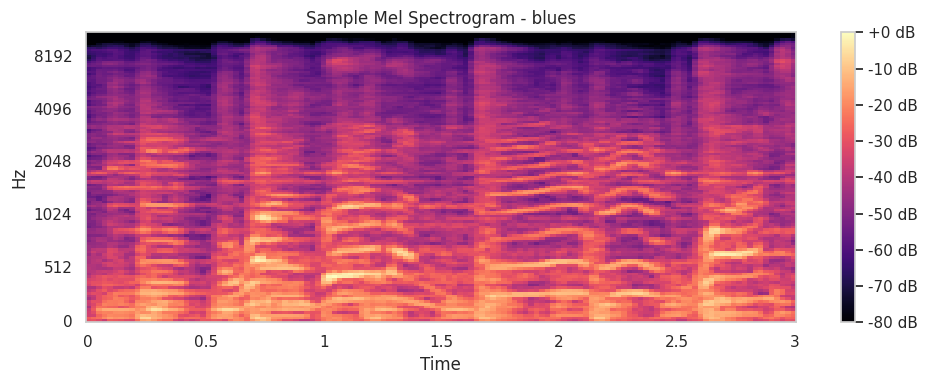


--- Fold 1 ---


I0000 00:00:1747279646.066317     508 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13709 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1747279660.864919     728 service.cc:152] XLA service 0x7f853c0147a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747279660.864954     728 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-05-15 08:27:41.950608: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747279664.075862     728 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-15 08:27:46.203511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12798', 20 bytes spill 

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step


/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Fold 1 Accuracy: 0.7166, F1-score: nan
              precision    recall  f1-score   support

       blues       0.79      0.72      0.76       200
   classical       0.94      0.88      0.91       200
     country       0.54      0.72      0.62       199
       disco       0.82      0.58      0.68       200
      hiphop       0.73      0.79      0.76       200
        jazz       0.87      0.56      0.68       198
       metal       0.95      0.86      0.90       200
         pop       0.60      0.78      0.68       200
      reggae       0.81      0.56      0.66       200
        rock       0.48      0.71      0.57       200

    accuracy                           0.72      1997
   macro avg       0.75      0.72      0.72      1997
weighted avg       0.75      0.72      0.72      1997



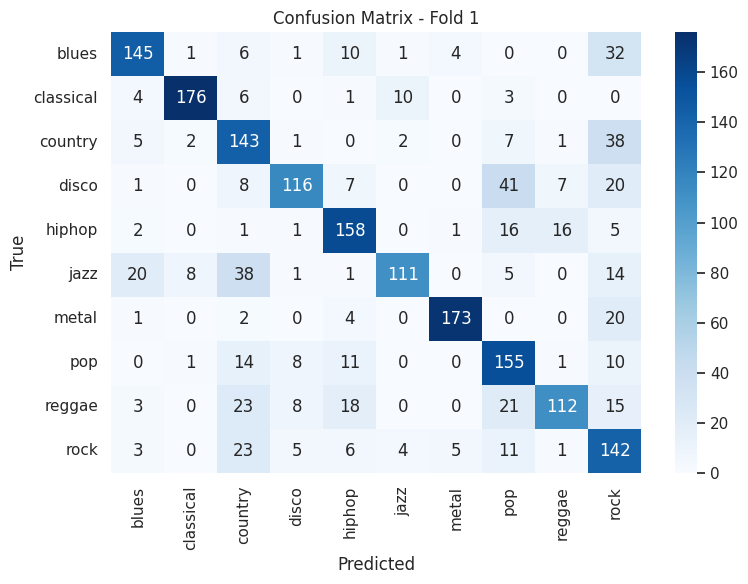

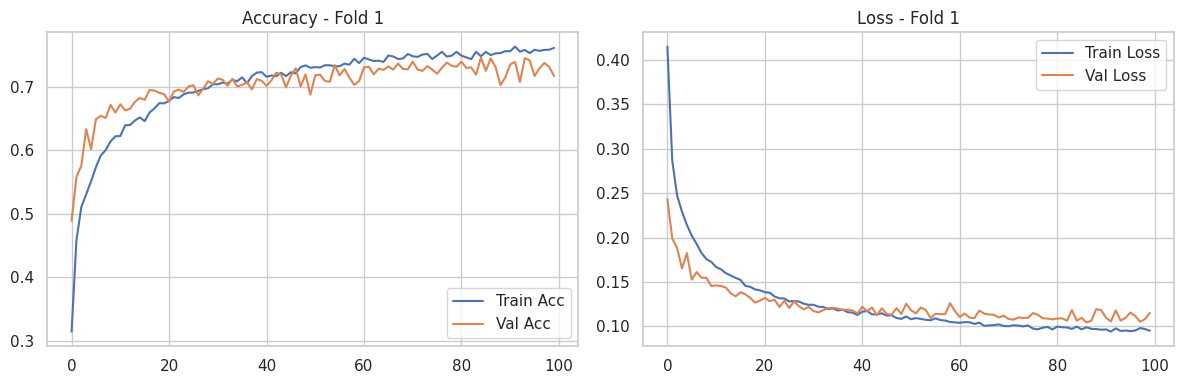


--- Fold 2 ---


2025-05-15 08:36:08.954506: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12798', 20 bytes spill stores, 20 bytes spill loads

2025-05-15 08:36:09.097497: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11385_0', 388 bytes spill stores, 892 bytes spill loads

2025-05-15 08:36:09.159196: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11385', 220 bytes spill stores, 220 bytes spill loads

2025-05-15 08:36:09.390466: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11385', 3960 bytes spill stores, 3948 bytes spill loads

2025-05-15 08:36:09.459901

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step
Fold 2 Accuracy: 0.7545, F1-score: nan
              precision    recall  f1-score   support

       blues       0.73      0.81      0.76       200
   classical       0.96      0.89      0.92       200
     country       0.66      0.76      0.71       199
       disco       0.64      0.64      0.64       200
      hiphop       0.86      0.70      0.77       200
        jazz       0.78      0.83      0.80       198
       metal       0.87      0.89      0.88       200
         pop       0.70      0.83      0.76       200
      reggae       0.74      0.71      0.72       200
        rock       0.64      0.50      0.56       199

    accuracy                           0.75      1996
   macro avg       0.76      0.75      0.75      1996
weighted avg       0.76      0.75      0.75      1996



/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


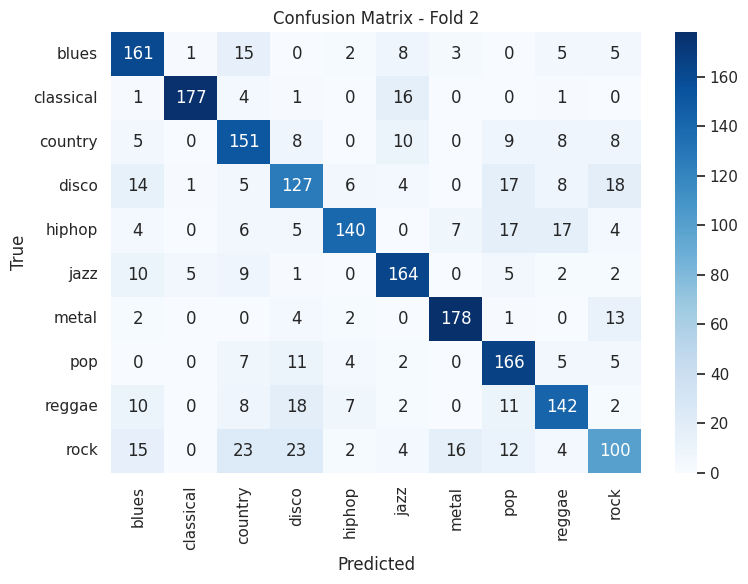

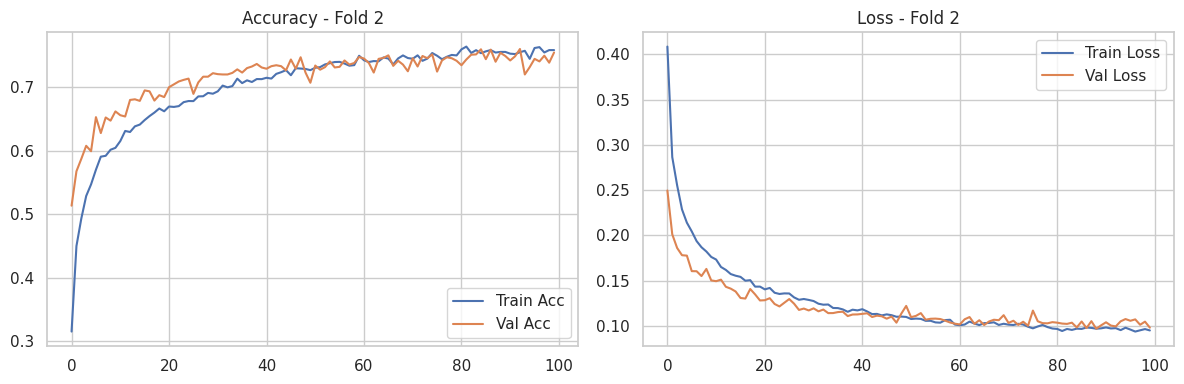


--- Fold 3 ---
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step
Fold 3 Accuracy: 0.7510, F1-score: nan
              precision    recall  f1-score   support

       blues       0.78      0.77      0.77       200
   classical       0.92      0.93      0.92       200
     country       0.71      0.71      0.71       199
       disco       0.83      0.47      0.60       200
      hiphop       0.78      0.77      0.77       199
        jazz       0.77      0.81      0.79       198
       metal       0.89      0.93      0.90       200
         pop       0.68      0.81      0.74       200
      reggae       0.65      0.74      0.69       200
        rock       0.57      0.59      0.58       200

    accuracy                           0.75      1996
   macro avg       0.76      0.75      0.75      1996
weighted avg       0.76      0.75      0.75      1996



/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


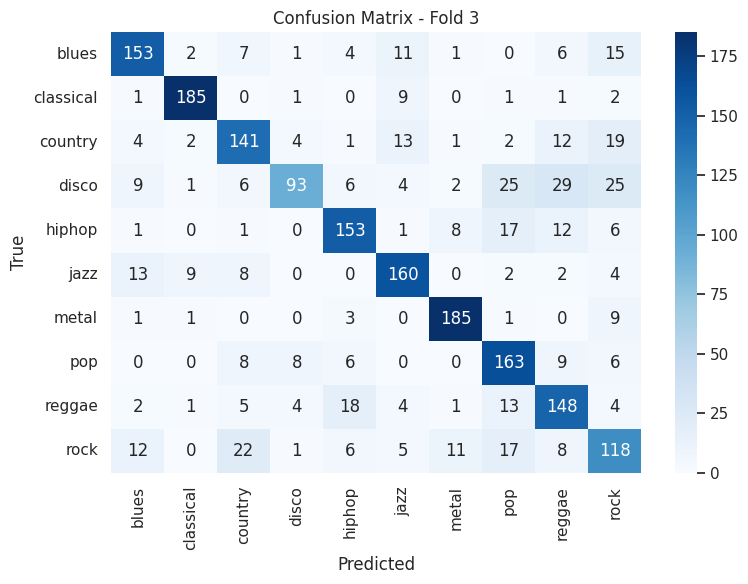

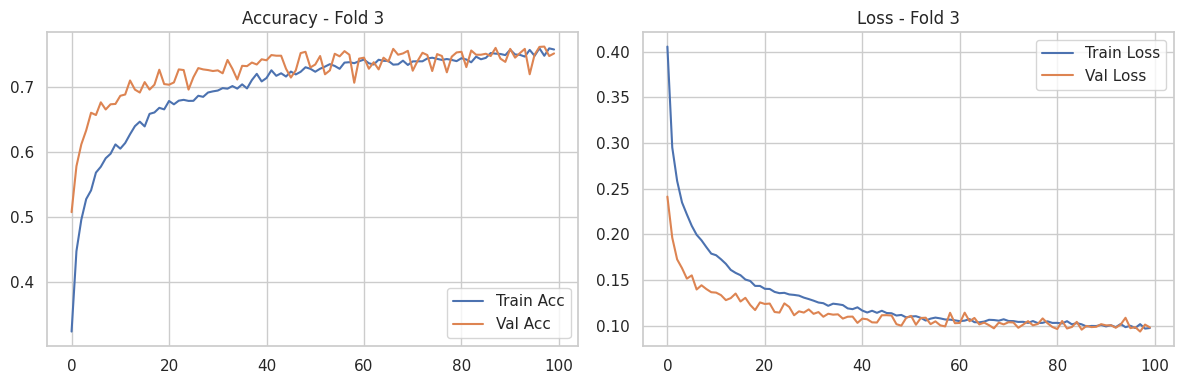


--- Fold 4 ---
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Fold 4 Accuracy: 0.7600, F1-score: nan
              precision    recall  f1-score   support

       blues       0.71      0.81      0.76       200
   classical       0.90      0.93      0.92       199
     country       0.79      0.64      0.71       200
       disco       0.58      0.78      0.66       200
      hiphop       0.77      0.77      0.77       199
        jazz       0.82      0.70      0.76       198
       metal       0.91      0.91      0.91       200
         pop       0.72      0.83      0.77       200
      reggae       0.77      0.71      0.74       200
        rock       0.71      0.52      0.60       200

    accuracy                           0.76      1996
   macro avg       0.77      0.76      0.76      1996
weighted avg       0.77      0.76      0.76      1996



/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


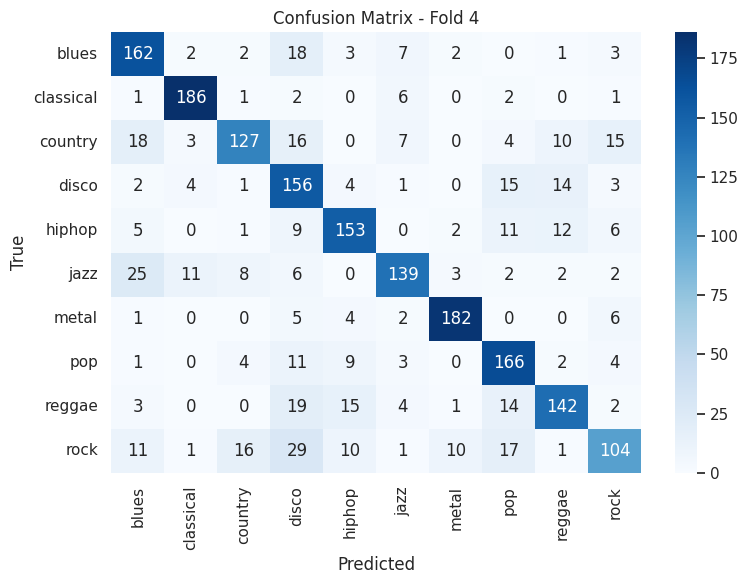

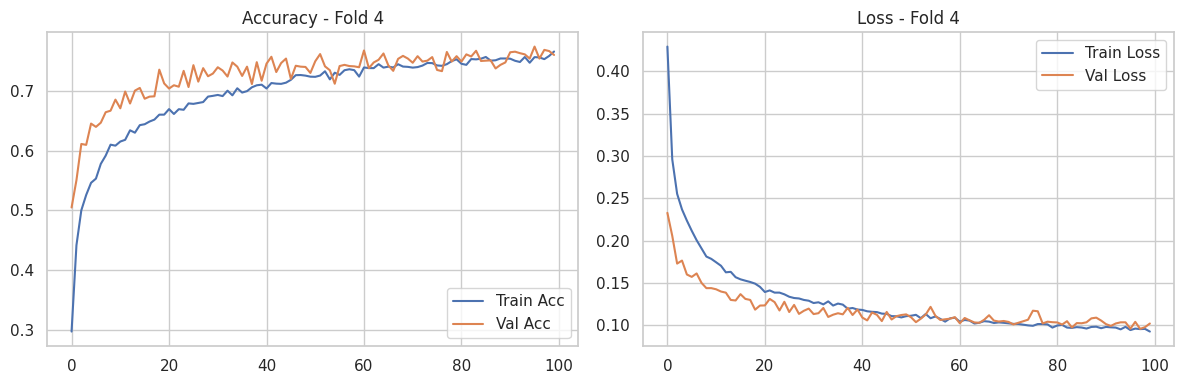


--- Fold 5 ---
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Fold 5 Accuracy: 0.7510, F1-score: nan
              precision    recall  f1-score   support

       blues       0.61      0.88      0.72       200
   classical       0.99      0.77      0.87       199
     country       0.69      0.69      0.69       200
       disco       0.69      0.69      0.69       199
      hiphop       0.80      0.78      0.79       200
        jazz       0.80      0.72      0.76       198
       metal       0.89      0.93      0.91       200
         pop       0.72      0.77      0.74       200
      reggae       0.74      0.78      0.76       200
        rock       0.68      0.52      0.59       200

    accuracy                           0.75      1996
   macro avg       0.76      0.75      0.75      1996
weighted avg       0.76      0.75      0.75      1996



/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/e/lab/Abdul_Rehman_Feb_New/conda/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


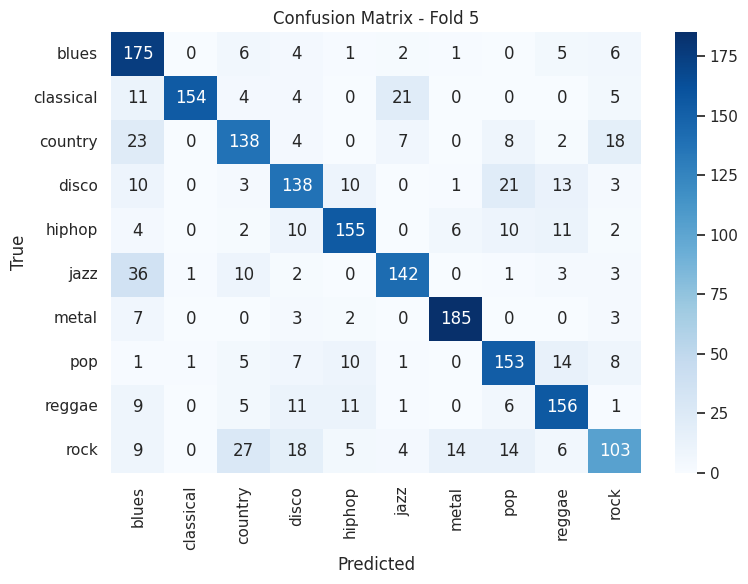

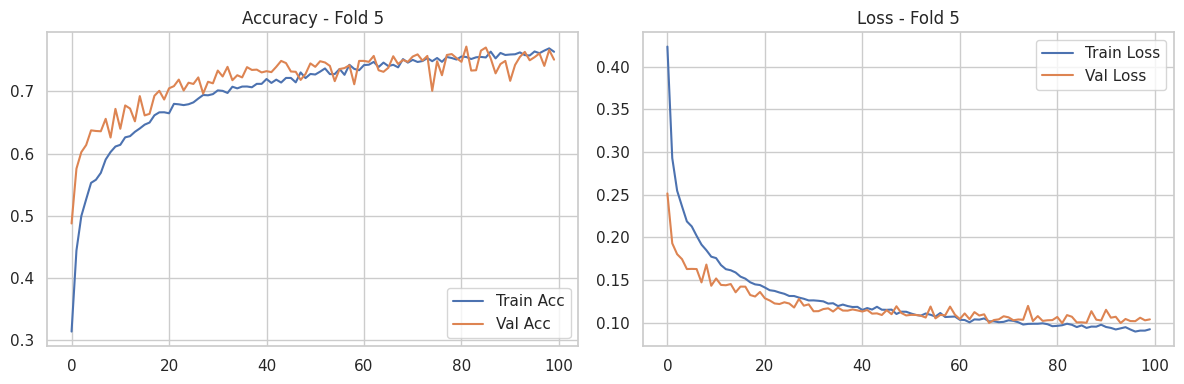


Average Accuracy: 0.7466
Average F1 Score: nan


In [1]:
# --- Imports ---
import os
import json
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import time
import math
import random

%matplotlib inline
sns.set(style="whitegrid")

# --- Paths ---
DATASET_PATH = r"/mnt/e/LAB/Abdul_Rehman_Feb_New/code/AML/Data/genres_original"
JSON_PATH = r"/mnt/e/lab/Abdul_Rehman_Feb_New/AML/data_gzgan.json"
FEATURES_PATH = "processed_features_mel_spec_notebook.npz"
MODEL_SAVE_PATH = "denseNet(201)_50layers.h5"
LABEL_MAP_PATH = "genre_label_mapping_notebook.json"

# --- Constants ---
SAMPLE_RATE = 22050
DURATION = 30
SEGMENT_DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
SAMPLES_PER_SEGMENT = int(SAMPLE_RATE * SEGMENT_DURATION)
NUM_SEGMENTS_PER_TRACK = int(SAMPLES_PER_TRACK / SAMPLES_PER_SEGMENT)

N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_FOLDS = 5

# --- Load Data ---
def load_data_paths_and_labels(dataset_path):
    if not os.path.exists(dataset_path):
        raise ValueError(f"Dataset path not found: {dataset_path}")
    all_files = []
    all_labels = []
    genre_mapping = {}
    genres = [g for g in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, g))]
    genres.sort()
    for i, genre in enumerate(genres):
        genre_mapping[i] = genre
        for filename in os.listdir(os.path.join(dataset_path, genre)):
            if filename.lower().endswith('.wav'):
                all_files.append(os.path.join(dataset_path, genre, filename))
                all_labels.append(i)
    if not all_files:
        raise ValueError("No audio files found.")
    return all_files, all_labels, genre_mapping

try:
    all_files, all_labels_int, genre_mapping = load_data_paths_and_labels(DATASET_PATH)
    with open(LABEL_MAP_PATH, 'w') as f:
        json.dump(genre_mapping, f, indent=4)
except ValueError as e:
    print(e)
    raise SystemExit("Stopping.")

data_df = pd.DataFrame({
    'file_path': all_files,
    'label_int': all_labels_int
})
data_df['genre'] = data_df['label_int'].map(genre_mapping)

# --- Feature Extraction ---
def extract_features(file_paths, labels_int, sr, n_mels, n_fft, hop_length, segment_duration, num_segments_per_track):
    processed_features = []
    processed_labels = []
    samples_per_segment = int(sr * segment_duration)
    num_expected_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    for i, file_path in enumerate(file_paths):
        try:
            signal, _ = librosa.load(file_path, sr=sr)
            if len(signal) < samples_per_segment:
                continue
            for s in range(num_segments_per_track):
                start_sample = s * samples_per_segment
                end_sample = start_sample + samples_per_segment
                if end_sample > len(signal): break
                audio_segment = signal[start_sample:end_sample]
                mel_spec = librosa.feature.melspectrogram(y=audio_segment, sr=sr, n_fft=n_fft,
                                                          hop_length=hop_length, n_mels=n_mels)
                log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
                if log_mel_spec.shape[1] != num_expected_vectors_per_segment:
                    pad = num_expected_vectors_per_segment - log_mel_spec.shape[1]
                    log_mel_spec = np.pad(log_mel_spec, ((0,0), (0,max(0, pad))), mode='constant')[:, :num_expected_vectors_per_segment]
                processed_features.append(log_mel_spec)
                processed_labels.append(labels_int[i])
        except:
            continue
    return np.array(processed_features), np.array(processed_labels)

# --- Load or Extract Features ---
if not os.path.exists(FEATURES_PATH):
    X_features, y_labels = extract_features(data_df['file_path'], data_df['label_int'],
                                            SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, SEGMENT_DURATION,
                                            NUM_SEGMENTS_PER_TRACK)
    np.savez(FEATURES_PATH, features=X_features, labels=y_labels)
else:
    data = np.load(FEATURES_PATH)
    X_features = data['features']
    y_labels = data['labels']

# --- Visualize ---
if X_features.size > 0:
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(X_features[0], sr=SAMPLE_RATE, hop_length=HOP_LENGTH,
                             x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Sample Mel Spectrogram - {genre_mapping[y_labels[0]]}")
    plt.tight_layout()
    plt.show()

# --- Prepare Data ---
X_features = X_features[..., np.newaxis]
X_features = np.repeat(X_features, 3, axis=-1)  # RGB
y_labels_cat = tf.keras.utils.to_categorical(y_labels)
input_shape = X_features.shape[1:]
num_classes = len(genre_mapping)

# --- Focal Loss ---
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, eps, 1. - eps)
        loss = -y_true * tf.keras.backend.log(y_pred)
        weight = alpha * tf.keras.backend.pow(1 - y_pred, gamma)
        return tf.keras.backend.sum(weight * loss, axis=1)
    return focal_loss_fixed

# --- Model Builder ---
def build_densenet_model(input_shape, num_classes, lr):
    base = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base.input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=focal_loss(), metrics=['accuracy'])
    return model

# --- Training with Stratified K-Fold ---
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
fold = 1
accs, f1s = [], []

for train_idx, val_idx in skf.split(X_features, y_labels):
    print(f"\n--- Fold {fold} ---")
    x_train, x_val = X_features[train_idx], X_features[val_idx]
    y_train, y_val = y_labels_cat[train_idx], y_labels_cat[val_idx]
    
    model = build_densenet_model(input_shape, num_classes, LEARNING_RATE)
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=0)

    # --- Evaluate ---
    y_pred = model.predict(x_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    acc = accuracy_score(y_true, y_pred_classes)
    accs.append(acc)
    report = classification_report(y_true, y_pred_classes, target_names=genre_mapping.values(), output_dict=True)
    f1 = np.mean([v['f1-score'] for k, v in report.items() if k.isdigit()])
    f1s.append(f1)

    print(f"Fold {fold} Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
    print(classification_report(y_true, y_pred_classes, target_names=genre_mapping.values()))

    # --- Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt="d", cmap="Blues",
                xticklabels=genre_mapping.values(), yticklabels=genre_mapping.values())
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # --- Plot Accuracy & Loss ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - Fold {fold}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - Fold {fold}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    fold += 1

print(f"\nAverage Accuracy: {np.mean(accs):.4f}")
print(f"Average F1 Score: {np.mean(f1s):.4f}")
